# difficult_mnist by Yoonhero

본 코드에서는 difficult_mnist 데이터셋 로딩과 기본적인 CNN baseline을 제공합니다.

About dataset
- 이미지 크기 (3x64x64)입니다.
- 3가지 색깔로 이루어진 펜으로 5가지 질감과 색이 다른 종이에 쓰인 숫자를 맞춰야 합니다.
- 숫자는 0-9로 구성되어 있습니다.
- 숫자의 위치는 랜덤하게 설정되었고, 숫자의 크기 도한 랜덤하게 설정되었습니다.

### Download and make Pytorch Dataloader.

Train, Validation을 나눌 필요가 있긴 합니다. 만약 그러신다면 본 라벨은 뒤죽박죽 섞여 있기에 로딩한 데이터셋을 적절히 인덱싱해서 나누어주세요. or train_test_split 코드 활용해보기

p.s. (Tensorflow의 경우는 ds = ds.with_format("tf"))을 사용하면 됩니다.

- 참고: https://huggingface.co/docs/datasets/en/use_with_tensorflow

In [10]:
from datasets import load_dataset

ds = load_dataset("yoonhero/difficult_mnist") # download 시간이 조금 소요될 수 있습니다.
device = "cuda" # 사용 가능한 accelerator 여부에 따라서 다음을 바꿔줍니다.
ds = ds.with_format("torch", device=device) # https://huggingface.co/docs/datasets/en/use_with_pytorch

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 69000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1000
    })
})


Text(0.5, 1.0, '8')

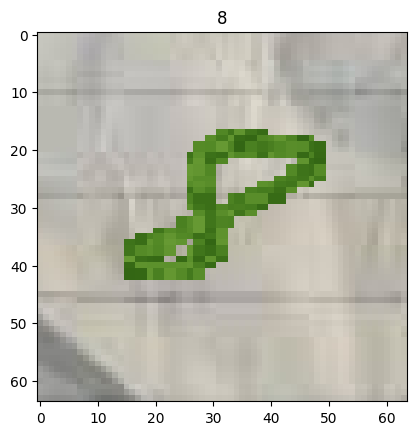

In [17]:
print(ds) # image와 label로 이루어져 있으며 ds["train"][rownum]로 접근할 수 있습니다.
import matplotlib.pyplot as plt
plt.imshow(ds["train"][0]["image"].permute(1, 2, 0).cpu().numpy())
plt.title(ds["train"][0]["label"].item())

In [24]:
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# train_data, val_data = train_test_split(ds["train"], )
batch_size = 128
dataloader = DataLoader(ds["train"], batch_size=batch_size, shuffle=False)

In [25]:
next(iter(dataloader)) # 0th batch!

{'image': tensor([[[[0.7804, 0.7765, 0.7725,  ..., 0.7529, 0.7333, 0.7020],
           [0.7765, 0.7725, 0.7686,  ..., 0.7490, 0.7216, 0.6980],
           [0.7765, 0.7686, 0.7647,  ..., 0.7294, 0.7020, 0.6980],
           ...,
           [0.6392, 0.6235, 0.6118,  ..., 0.7922, 0.7569, 0.7804],
           [0.6275, 0.6157, 0.6039,  ..., 0.7725, 0.7451, 0.7569],
           [0.5804, 0.5686, 0.5569,  ..., 0.7490, 0.7294, 0.6902]],
 
          [[0.7804, 0.7765, 0.7725,  ..., 0.7412, 0.7216, 0.6902],
           [0.7765, 0.7725, 0.7686,  ..., 0.7294, 0.7020, 0.6784],
           [0.7765, 0.7686, 0.7647,  ..., 0.7098, 0.6824, 0.6784],
           ...,
           [0.6392, 0.6235, 0.6118,  ..., 0.7765, 0.7412, 0.7647],
           [0.6275, 0.6157, 0.6039,  ..., 0.7569, 0.7294, 0.7412],
           [0.5804, 0.5686, 0.5569,  ..., 0.7333, 0.7137, 0.6745]],
 
          [[0.7490, 0.7451, 0.7412,  ..., 0.7216, 0.7020, 0.6706],
           [0.7451, 0.7412, 0.7373,  ..., 0.7059, 0.6784, 0.6549],
           [0.7

In [26]:
for batch in dataloader:
    images = batch["image"]
    label = batch["label"]
    print(images.shape, label.shape)
    break

torch.Size([128, 3, 64, 64]) torch.Size([128])


### Baseline Example

간단한 CNN 네트워크 및 학습 코드입니다.

*주의*

너무 간단해서 잘 작동하지 않을거에요..

개선점
- 1x28x28 -> 3x64x64 커진 이미지를 어떻게 처리할까? -> imagenet!(256x256)
- 숫자의 영역에만 attend해서 예측할 수는 없을까? -> https://www.youtube.com/watch?v=ByjaPdWXKJ4 "1:00:20부터"
- 색깔이 아닌 형태에만 집중하고 있을까? -> deeper analysis on CNN feature act visualization!

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvBlock(nn.Module):
    def __init__(self, indim, outdim):
        super().__init__()

        self.conv1 = nn.Conv2d(indim, indim*3, (3, 3), stride=1, padding=(1, 1))
        self.conv2 = nn.Conv2d(indim*3, outdim, (3, 3), stride=1, padding=(1, 1))
        self.act = nn.ReLU()
        self.norm0 = nn.BatchNorm2d(indim)
        self.norm1 = nn.BatchNorm2d(indim*3)

        self.conv0 = nn.Conv2d(indim, outdim, (1, 1), stride=1)

    def forward(self, x):
        xx = self.act(self.norm0(x))
        xx = self.act(self.norm1(self.conv1(x)))
        xx = self.conv2(xx)
        x = self.conv0(x)+xx
        return x

class Network(nn.Module):
    def __init__(self): # 64 -> 32 -> 16 -> 8
        super().__init__()
        self.pool = nn.MaxPool2d(2, 2)

        self.convblock0 = ConvBlock(3, 16)
        self.convblock1 = ConvBlock(16, 32)
        self.convblock2 = ConvBlock(32, 64) # 64x8x8

        self.dropout = nn.Dropout(0.25)

        self.projection0 = nn.Linear(64*8*8, 512)
        self.projection1 = nn.Linear(512, 10)

        self.act = nn.ReLU()

    def forward(self, x, y=None):
        B = x.size(0)
        x = self.pool(self.convblock0(x))
        x = self.pool(self.convblock1(x))
        x = self.pool(self.act(self.convblock2(x)))
        x = x.view(B, -1)
        x = self.act(self.projection0(x))
        x = self.dropout(x)
        x = self.projection1(x)
        loss = None
        if y is not None:
            loss = F.cross_entropy(x, y, reduction="mean")
        return x, loss

In [28]:
net = Network().to(device)
# net(next(iter(dataloader))["image"])
lr = 0.001
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

In [29]:
import tqdm
max_epoch = 20
for epoch in range(max_epoch):
    loss_accum = 0
    total_acc = 0
    max_n = 0
    for n, batch in enumerate(tqdm.tqdm(dataloader)):
        images = batch["image"]
        labels = batch["label"]
        if n * batch_size > 60000: # 60000 train / 9000 val
            with torch.no_grad():
                net.eval()
                y, _ = net(images)
                total_acc += (y.argmax(-1)==labels).sum(0).item()
                continue
        else:
            max_n = n+1
        y, loss = net(images, labels)
        loss_accum += loss.item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    print(f"epoch: {epoch} loss: {loss_accum/(max_n)} val acc: {total_acc/(n+1-max_n)}")

  2%|█▉                                                                            | 13/540 [00:38<25:54,  2.95s/it]


KeyboardInterrupt: 

In [ ]:
@torch.no_grad
def eval_function(network, batch_size=64):
    test_dataloader = DataLoader(ds["test"], batch_size=batch_size, shuffle=False)
    net.eval() # disable dropout(activates on train stage)
    sols = []
    for batch in tqdm.tqdm(test_dataloader):
        images = batch["image"]
        y, _ = network(images)
        sols += y.argmax(-1).tolist()
    net.train()
    return sols